In [3]:
from scipy.integrate import solve_ivp
from plotly import tools
from plotly.offline import init_notebook_mode, plot, iplot
from tqdm.notebook import tqdm
import numpy as np
import math
import pandas as pd
import OMPython
import os
init_notebook_mode(connected=True)

In [4]:
# OpenModelicaファイルのPATHの指定
model_name = "CoolingBottle.mo"
model_path = os.path.join(os.getcwd(), model_name).replace(os.path.sep, '/')

# OpenModelicaモデル読み込み
model = OMPython.ModelicaSystem(
    model_path,
    os.path.splitext(model_name)[0],
    ["Modelica"]
)

output_labels = [
    "time",
    "T_milk",
    "T_bottle",
]

Notification: Automatically loaded package Modelica 4.0.0 due to uses annotation.
Notification: Automatically loaded package Complex 4.0.0 due to uses annotation.
Notification: Automatically loaded package ModelicaServices 4.0.0 due to uses annotation.



In [6]:
# パラメータリストが記載されたcsvの読み込み
df_params = pd.read_csv("CoolingBottleParameters.csv", index_col=0)
print(df_params)

           初期ミルク温度 [K]  初期ボトル温度 [K]  冷却水温度 [K]  熱伝達係数*面積 [W/K]  \
条件名                                                              
ガラス哺乳瓶          363.15       363.15     288.15            67.4   
プラスチック哺乳瓶       363.15       363.15     288.15            17.9   

           ボトル熱コンダクタンス [W/K]  ミルク熱容量 [J/K]  ボトル熱容量 [J/K]  
条件名                                                       
ガラス哺乳瓶                 12.40           336          75.4  
プラスチック哺乳瓶               3.28           336          75.4  


In [17]:
# 条件数を取得
rows_num = len(df_params)

# 初期値リスト
t0_milk_list = [df_params.iloc[i,0] for i in range(rows_num)]
t0_bottle_list = [df_params.iloc[i,1] for i in range(rows_num)]
t_water_list = [df_params.iloc[i,2] for i in range(rows_num)]

# モデルパラメータリスト
h_interface_list = [df_params.iloc[i,3] for i in range(rows_num)]
g_bottle_list = [df_params.iloc[i,4] for i in range(rows_num)]
hc_milk_list = [df_params.iloc[i,5] for i in range(rows_num)]
hc_bottle_list = [df_params.iloc[i,6] for i in range(rows_num)]

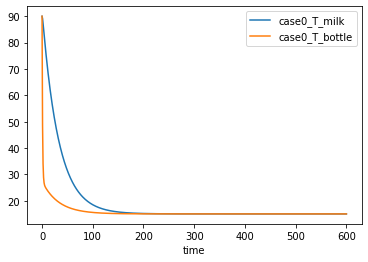

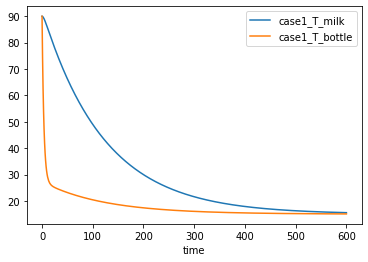

In [20]:
# 計算時間の設定
time_start = 0.0 # [s]
time_stop = 10.0 * 60 # [s]

# 計算時の時間刻み
dt = 1.0 # [s]
step_size = dt
model.setSimulationOptions([
    f"startTime={time_start}",
    f"stopTime={time_stop}",
    f"stepSize={step_size}"
])

for i in range(rows_num):
    # 初期値をリストから取得
    t0_milk = t0_milk_list[i]
    t0_bottle = t0_bottle_list[i]
    t_water = t_water_list[i]
    
    # モデルパラメータをリストから取得
    h_interface = h_interface_list[i]
    g_bottle = g_bottle_list[i]
    hc_milk = hc_milk_list[i]
    hc_bottle = hc_bottle_list[i]

    # モデルパラメータ変更
    model.setParameters([
        f"T0Milk={t0_milk}",
        f"T0Bottle={t0_bottle}",
        f"TWater={t_water}",
        f"HInterface={h_interface}",
        f"GBottle={g_bottle}",
        f"HCMilk={hc_milk}",
        f"HCBottle={hc_bottle}",
    ])

    # Simlation実行
    model.simulate()
    
    # 結果取得
    res_array = model.getSolutions(output_labels)

    df_res = pd.DataFrame(res_array.T, columns=output_labels)

    # indexをtimeに設定
    df_res.set_index("time", inplace=True)

    # Kを℃に変換
    df_res = df_res - 273.15 
    
    df_res = df_res.add_prefix(f"case{i}_")

    df_res.plot()

